# Solving a HANK model using the `IndShockConsumerType`

This notebook solves a Heterogeneous Agent model using HARK and computes Jacobians. These are used as inputs for the [Sequence-Space Toolbox](https://github.com/shade-econ/nber-workshop-2022) which adds general equilibrium components.

This is possible as they [write](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb):

'If you wish to solve a model that's not just a variation on these off-the-shelf HetBlocks, there's two cases to consider.

1. The model fits into the HetBlock paradigm. E.g., standard incomplete markets models with additional choices such as search intensity. All you need to do is write a new backward iteration function. Use it to instantiate a new HetBlock and get all the HetBlock methods for free.

2. The model does not fit the HetBlock paradigm. E.g., models in which discrete endogenous states. In this case, we recommend that you "bring your own Jacobian". That is, solve the Jacobian of your block outside the SSJ toolkit. Once you turn them into an instance of JacobianDict (like we did in section 4 of the Krusell-Smith notebook), you can include them in models in lieu of an actual block. This is sufficient for using linear solution methods (impulse_linear, jacobian and their solved_ versions) at the macro model level.'

We want to use option 2!

Author: Adrian Monninger & Will Du

## TODO LIST
### Short Term
- Deficit spending goods market is off
- solve RA
- solve TA
- Compare with SSJ
- points: Jacobians = 300-400; Solution = 40/50 --> Have different parameters
- target MPC for steady state values of B and beta


### Med Term:
- Allow for Monetary Policy Shock
- Add other Consumer Types
- Why use HARK? (Can we showcase the different discount rate things?)

## Achievement List
- Get Jacobians from ConsIndShockModel
- Update construct_lognormal_income_process_unemployment in ConsIndShockModel.py
- Add Jacobians
- Add Steady State values 
- Create IRFs

## Open Questions


In [1]:
#from ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
#import numba
import time

from scipy import optimize

# Step 1: Partial Equilibrium using `IndShockConsumerType`

## 1. Solving `IndShockConsumerType`

In [2]:
#Steady State values
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T


r_ss = 1.03 - 1
G_ss = .2
B_ss = .15 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

T_ss: 0.20450000000000004
Z_ss: 0.7955
C_ss: 0.8


In [3]:
#------------------------------------------------------------------------------------------------------
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
}
T = 300 # Dimention of TxT Jacobian matrix

In [4]:
# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    
    return z

Dict['TranShkMean_Func'] = [function]

In [5]:
Agent = IndShockConsumerType(**Dict, verbose = False)
Agent.aXtraCount = 500

## 2. Compute Partial Equilibrium Steady State

In [6]:
start = time.time()
Agent.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

Seconds to compute steady state 9.975016593933105


## 3. Compute Jacobians
See [Jacobian Notebook](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Jacobian_Example.ipynb)
Shocks possible: LivPrb, PermShkStd,TranShkStd, DiscFac,UnempPrb, Rfree, IncUnemp, DiscFac

We use here: Rfree and labor

In [7]:
start = time.time()

CJACR, AJACR = Agent.calc_jacobian('Rfree',T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 10.021287441253662


In [33]:
len(CJACR)

300

Plot: Consumption Jacobians

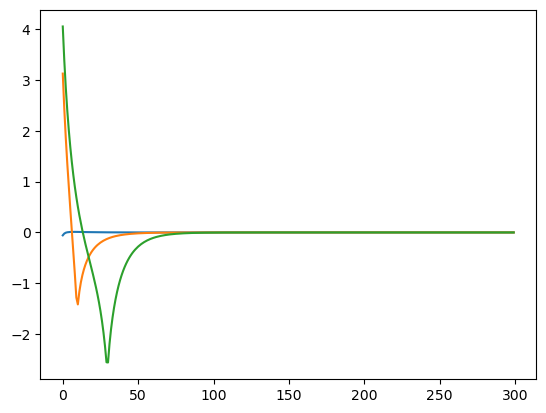

In [8]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[10])
plt.plot(CJACR.T[30])
plt.show()

In [9]:
CJACN,AJACN = Agent.calc_jacobian('labor', T)

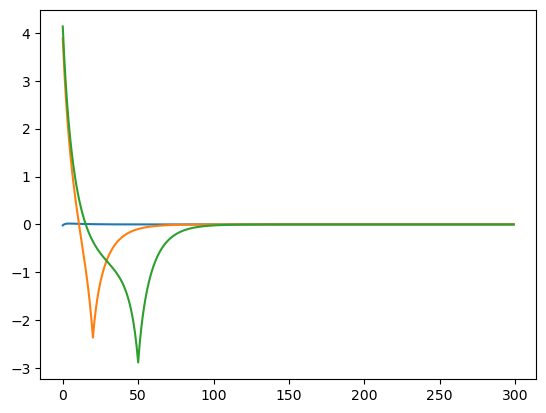

In [10]:
plt.plot(CJACN.T[0])
plt.plot(CJACN.T[20])
plt.plot(CJACN.T[50])
plt.show()

## 4. Compute General Equilibrium Steady State

In [11]:
def ss_func(beta):
    Agent.DiscFac = beta
    A_ss = Agent.compute_steady_state()[0]
    #J_ss = Agent.calc_jacobian()[0][0]
    return A_ss
    

def ss_dif(beta):
    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss #0.25 # MPC target
DiscFac = optimize.brentq(ss_dif,.75,.99)

print('beta:' +str(Agent.DiscFac))
# Verify solution
print('Assets: ' +str(Agent.A_ss))
print('Asset Target:' +str(Asset_target))
print('Consumption: ' + str(Agent.C_ss))

beta:0.9254886535407717
Assets: 0.14999999999674615
Asset Target:0.15
Consumption: 0.8003124999998011


In [12]:
Dict['DiscFac'] = DiscFac
Agent_ss = IndShockConsumerType(**Dict, verbose = False)
Agent_ss.aXtraCount = 500

In [13]:
#Agent_ss.solve()
Agent_ss.compute_steady_state()
A_ss = Agent_ss.A_ss
B_ss = Agent_ss.A_ss
T_ss = fiscal_ss(B_ss,r_ss,G_ss)

## 5. Compute Jacobians with new Steady State

In [14]:
start = time.time()

CJACR_GE, AJACR_GE = Agent_ss.calc_jacobian('Rfree',T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 10.21426248550415


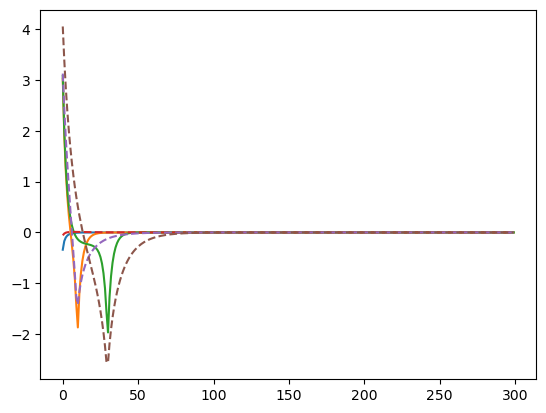

In [15]:
plt.plot(CJACR_GE.T[0])
plt.plot(CJACR_GE.T[10])
plt.plot(CJACR_GE.T[30])
plt.plot(CJACR.T[0],'--')
plt.plot(CJACR.T[10],'--')
plt.plot(CJACR.T[30],'--')
plt.show()

In [16]:
CJACN_GE, AJACN_GE = Agent_ss.calc_jacobian('labor', T)

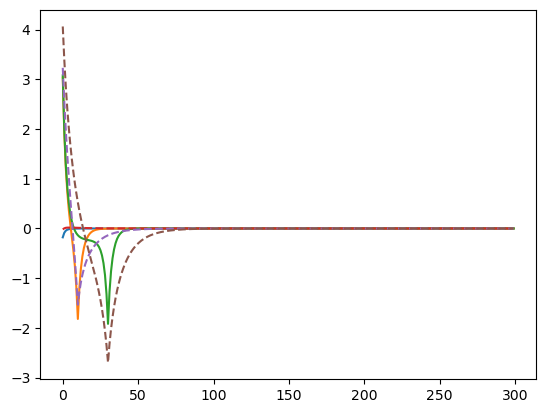

In [17]:
plt.plot(CJACN_GE.T[0])
plt.plot(CJACN_GE.T[10])
plt.plot(CJACN_GE.T[30])
plt.plot(CJACN.T[0],'--')
plt.plot(CJACN.T[10],'--')
plt.plot(CJACN.T[30],'--')
plt.show()

## 6. Set Up General Equilibrium Parts
We use here [HANK with Fiscal Policy](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb). A very simple model without labor market or monetary policy

In [18]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt


### 6.1 Include Steady State Dictionary Into SSJ

In [19]:
HARK_SteadyState_Dict = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss })
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )

### 6.2 Create Jacobians from GE parts

In [20]:
J_fiscal = fiscal.jacobian(HARK_SteadyState_Dict, inputs=['B', 'G', 'Y'])

In [21]:
J_fiscal['T']

{'B': SimpleSparse({(-1, 0): 1.030, (0, 0): -1.000}),
 'G': SimpleSparse({(0, 0): 1.000})}

## 7. Generate General Equilibrium Jacobians

### 7.1 By Hand (TBD)

In [22]:
# print(HARK_Jacobian_Dict['C']['G'] @ J_fiscal['G']['T'])

### 7.2 Using SSJ

In [23]:
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

# T = 300
G_std = .01
G_persistence = .9
dG =  G_std*G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [24]:
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

In [25]:
irfs_G

<ImpulseDict: ['G', 'Y', 'C', 'A', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']>

In [26]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

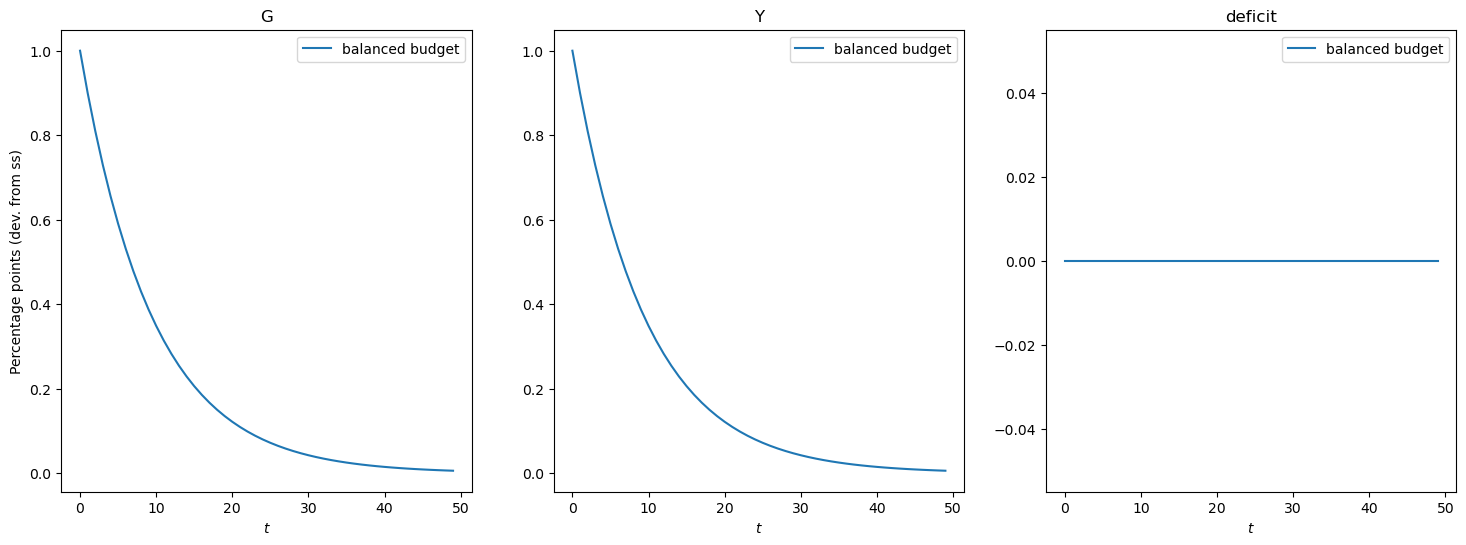

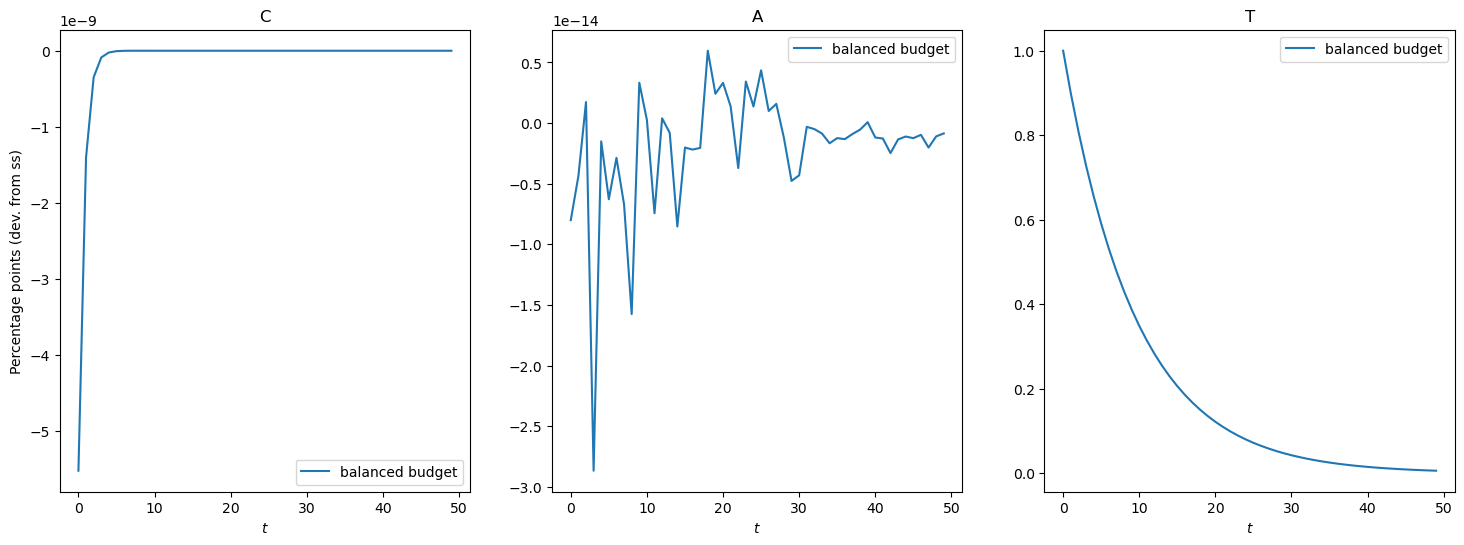

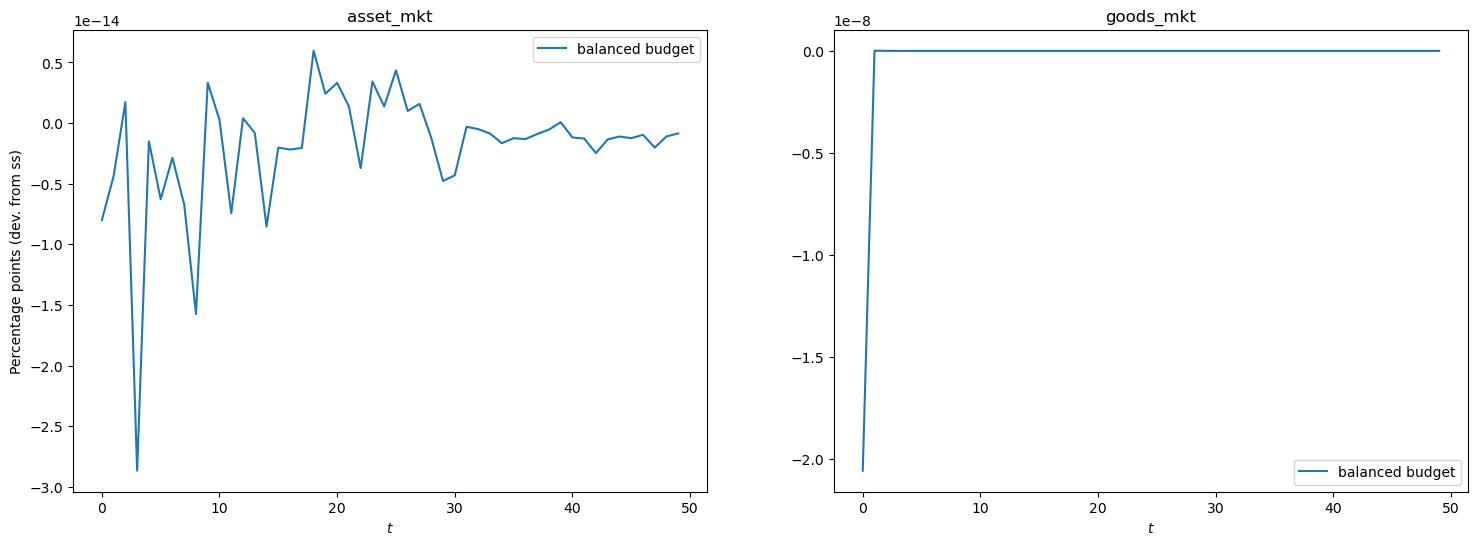

In [27]:
show_irfs([irfs_G], ['G', 'Y', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['C', 'A', 'T'], labels=["balanced budget"])
show_irfs([irfs_G], ['asset_mkt', 'goods_mkt'], labels=["balanced budget"])

In [28]:
# Deficit Spending
rho_B = 0.9
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

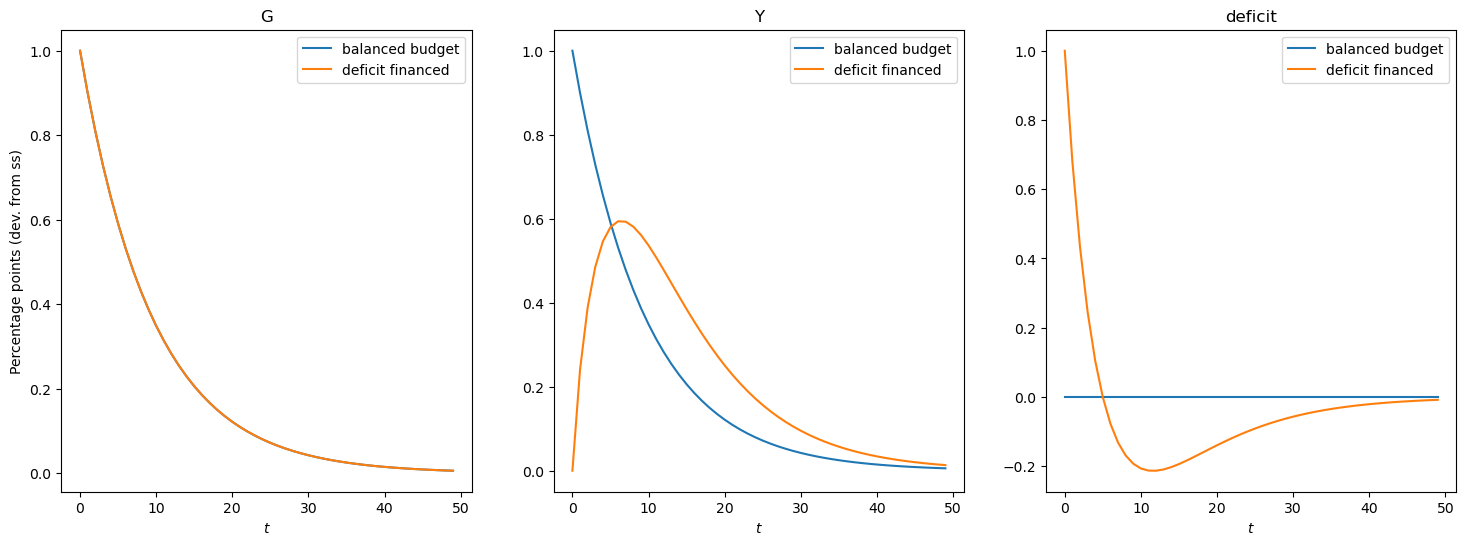

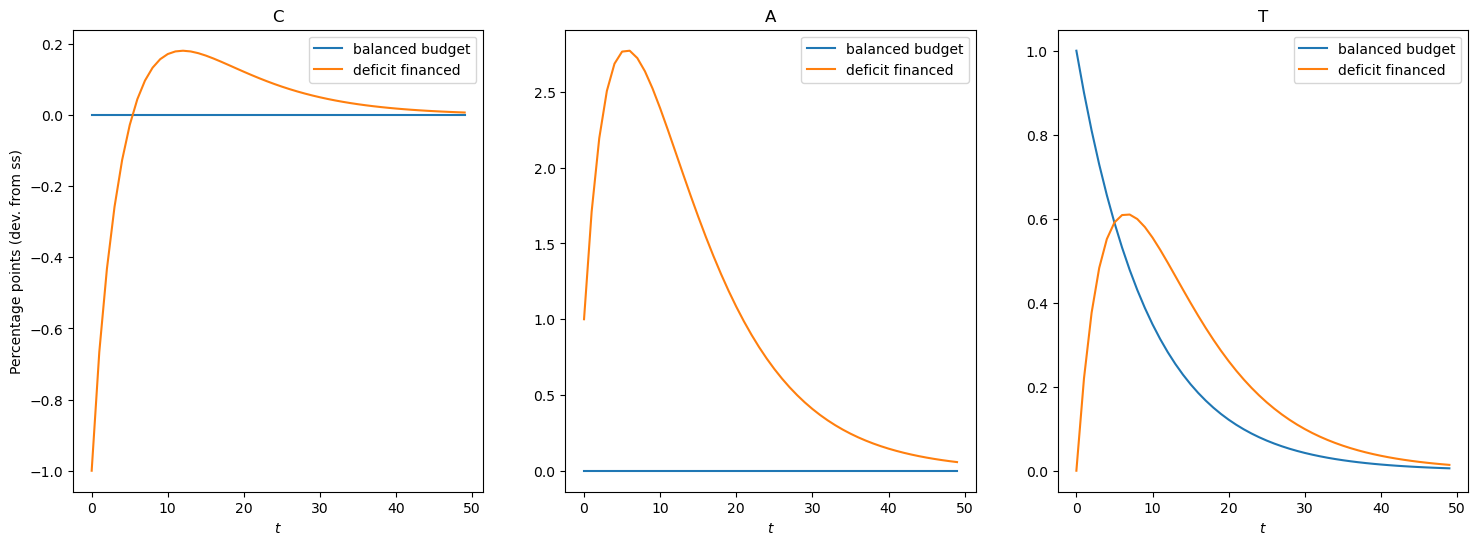

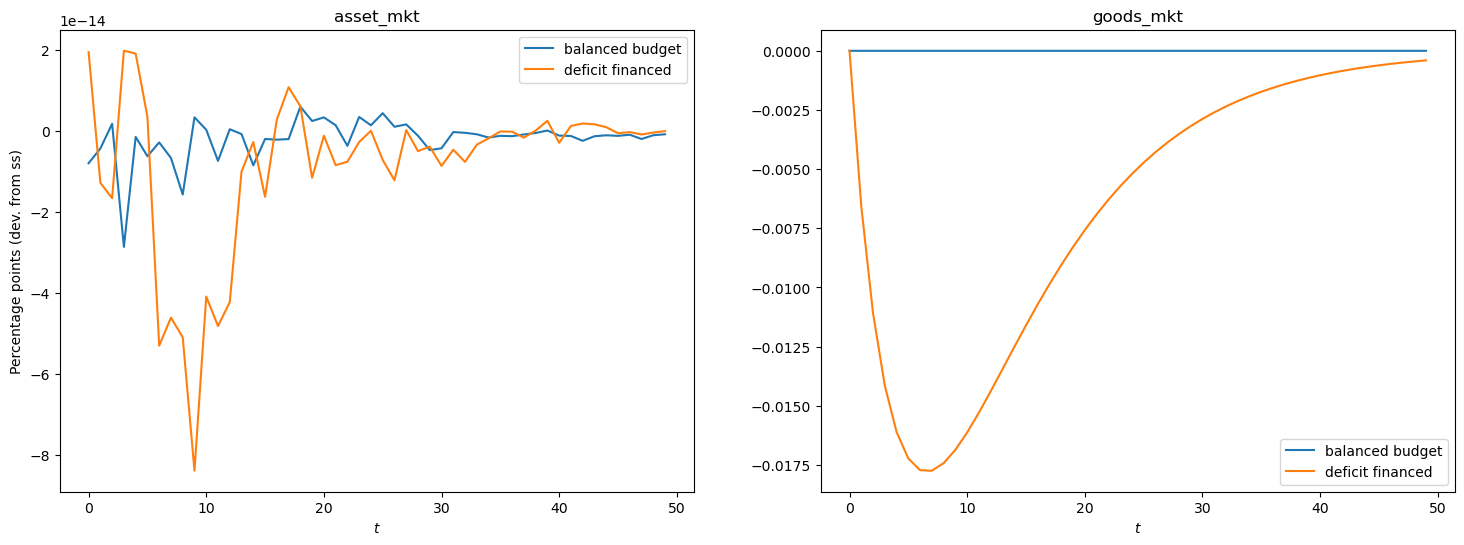

In [29]:
show_irfs([irfs_G, irfs_B], ['G', 'Y', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['C', 'A', 'T'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])

In [30]:
STOP

NameError: name 'STOP' is not defined

# Comparison with SSJ
Now, let's compare impulse response functions from SSJ and HARK.

### 

### Get Household Poblem into a Block structure such that SSJ can use it
We have to include HARK Jacobians and the steady state values. Afterwards, SSJ calculates Jacobians for the GE block and creates GE Jacobians

PROBLEM: SSJ actively wants to solve for the steady state which results in errors

In [ ]:
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )

In [ ]:
HARK_SteadyState_Dict = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss })

In [ ]:
# 1)
ss_HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

G_std = .001
G_persistence = .9
regular_G_shock_path = {"G": G_std*G_persistence**np.arange(200)}

Dict_HARK_HANK = {"deficit": G_ss - T_ss, "T": T_ss, "Z": Y_ss - T_ss, "G": 1.0, "asset_mkt":0.0, "goods_mkt": 0.0,  "C": C_ss,"r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [ ]:
ss_HARK_HANK = ss_HARK_HANK.steady_state(Dict_HARK_HANK)

In [ ]:
vars(ss_HARK_HANK)

In [ ]:
# 2) Create a Block with 2 dictionaries which includes steady_state
class HARK_block(Block):
    """
    The HARK block needs two ingredients.
    1. JacobianDict: A dictionary with Jacobians
    2. steady_state: A dictionary with steady state values
    """
#     def Jacobian():
#         JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
    
#     def Steady_State():
#         SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss })
        
    Jacobian = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
    Steady_State = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
    UserProvidedSS = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [ ]:
HARK_Input = HARK_block
HARK_Input.Jacobian['A']

In [ ]:
ss_HARK_HANK = create_model([HARK_Input,fiscal,mkt_clearing])


In [ ]:
# 3) Create a Result Dictionary
class HARK_Dict(ResultDict):
#     def __init__(self):
#         self.Jacobian = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
#         self.steady_state = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
        
    Jacobian = JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } )
    Steady_State = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
    UserProvidedSS = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [ ]:
HARK_Inputb = HARK_Dict

In [ ]:
HARK_Inputb.Jacobian['A']

In [ ]:
HARK_Inputb.Steady_State

In [ ]:
ss_HARK_HANK = create_model([HARK_Inputb, fiscal, mkt_clearing])
## This error in combine comes even before

In [ ]:
# 4) Use the ResultDict directly
HARK_Inputc = ResultDict(JacobianDict( { 'C' : {'Z' : CJACN_GE} ,'A' : {'Z' : AJACN_GE} } ))

In [ ]:
# 5) Use options for steady state
ss_HARK_HANK = create_model([HARK_Jacobian_Dict,fiscal,mkt_clearing], name="HARK_HANK")


In [ ]:
vars(ss_HARK_HANK)

In [ ]:
ss_HARK_HANK.steady_state_options = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }

In [ ]:
ss_HARK_HANK.steady_state

In [ ]:
ss_HARK_HANK = ss_HARK_HANK.steady_state(Dict_HARK_HANK)

In [ ]:
# 6 Add to JacobianDictBlock
ss_HARK_HANK.blocks

In [ ]:
ss = {"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss }
ss_HARK_HANK.partial_jacobians(ss)

## Create Impulse Responses

In [ ]:
IPR = ss_HARK_HANK.solve_impulse_linear(Dict_HARK_HANK, unknowns, targets, regular_G_shock_path, T=200)

In [ ]:
STOP

In [ ]:
# create hh
# From 

# {'backward_fun': <ExtendedFunction(hh): ['Va_p', 'a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi'] -> ['Va', 'a', 'c', 'n']>, 
# 'name': 'hh', 'M': Bijection({}), 'steady_state_options': {'backward_tol': 1e-08, 'backward_maxit': 5000, 'forward_tol': 1e-10, 'forward_maxit': 100000}, 
# 'impulse_nonlinear_options': {'monotonic': False}, 'impulse_linear_options': {'h': 0.0001, 'twosided': False}, 
# 'jacobian_options': {'h': 0.0001, 'twosided': False}, 'partial_jacobians_options': {}, 'exogenous': OrderedSet(['Pi']), 'policy': OrderedSet(['a']), 
# 'backward': OrderedSet(['Va']), 'non_backward_outputs': OrderedSet(['a', 'c', 'n']), 'outputs': OrderedSet(['A', 'C', 'N']), 
# 'M_outputs': Bijection({'a': 'A', 'c': 'C', 'n': 'N'}), 'inputs': OrderedSet(['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']), 
# 'internals': OrderedSet(['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n']), 'original_inputs': OrderedSet(['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi']), 
# 'original_outputs': OrderedSet(['A', 'C', 'N']), 'original_internals': OrderedSet(['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'n']), 'original_M_outputs': Bijection({'a': 'A', 'c': 'C', 'n': 'N'}), 
# 'hetinputs': None, 'hetoutputs': None, 'backward_init': <ExtendedFunction(hh_init): ['a_grid', 'we', 'r', 'eis', 'T'] -> ['fininc', 'Va']>}


hh = {'name' : 'hh',
    'inputs' : ['a_grid', 'we', 'T', 'r', 'beta', 'eis', 'frisch', 'vphi', 'Pi'],
    'outputs' : = ['A', 'C', 'N']
    
}

In [ ]:
hh_ext = {
    inputs = OrderedSet(['r', 'beta', 'eis', 'frisch', 'vphi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Tax', 'w'])
    outputs = ['A', 'C', 'N', 'NE']
    partial_jacobians = 
    steady_state = 
}

In [ ]:
# Add Steady State.
## I found in blocks/block:
"""
    def steady_state(self, calibration: Union[SteadyStateDict, UserProvidedSS], 
                     dissolve: List[str] = [], options: Dict[str, dict] = {}, **kwargs) -> SteadyStateDict:
"""
hh_ext['UserProvidedSS'] = {}

# Step 2: General Equilibrium Part Using Sequence Space Method
Following the [SSJ](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb) and creating other market participants as simple blocks

In [ ]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

Partial Equilibria for maro blocks

In [ ]:
## Put Blocks together
blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

In [ ]:
## Steady States
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [ ]:
## Solve Jacobians
## NOTE: our HARK Jacobians are already included and are just used as given
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

### a) Combining Partial Equilibrium Jacobians to make them General Equilibrium. Instead of using `CombinedBlock`

In [ ]:
J_r_rante = models['ha']['ex_post_rate'].jacobian(ss['ha'], ['r_ante'], T=T)['r']['r_ante']
J_C_r = models['ha']['hh'].jacobian(ss['ha'], ['r'], T=T)['C']['r']

dC_dr_manual = J_C_r @ J_r_rante @ dr

assert np.all(np.isclose(dC_dr['ha'], dC_dr_manual))


### b) Using linear solution methods (`impulse_linear`, `jacobian` and their `solved_` versions) at the macro model level.